# Planner quality

This notebook compares exhaustive oracle, greedy, and dynamic programming strategies on small circuits (≤ 20 qubits) using the planner's public interface and updated cost heuristics (entanglement-aware MPS, decision-diagram weighting).


Figures are saved to `../figures/` and tables to `../results/`.


In [ ]:
from pathlib import Path
FIGURES_DIR = Path('../figures')
RESULTS_DIR = Path('../results')
FIGURES_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)
try:
    import ipynbname
    NB_NAME = ipynbname.path().stem
except Exception:  # pragma: no cover
    NB_NAME = 'notebook'


In [1]:
import time, random, importlib, subprocess, sys, numpy as np
from quasar import CostEstimator, Cost, Backend
from quasar.circuit import Circuit, Gate
from quasar.planner import Planner, PlanStep
from quasar.partitioner import CLIFFORD_GATES
from quasar import config
from benchmarks import circuits as circuit_lib

# ensure required libraries
for pkg in ["pandas", "matplotlib"]:
    if importlib.util.find_spec(pkg) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])
import pandas as pd
import matplotlib.pyplot as plt


def add_cost(a, b):
    return Cost(
        time=a.time + b.time,
        memory=max(a.memory, b.memory),
        log_depth=max(a.log_depth, b.log_depth),
        conversion=a.conversion + b.conversion,
        replay=a.replay + b.replay,
    )


def better(a, b):
    return (a.time, a.memory) < (b.time, b.memory)


def simulation_cost(estimator, backend, num_qubits, num_1q_gates, num_2q_gates, num_meas):
    if backend == Backend.TABLEAU:
        return estimator.tableau(num_qubits, num_1q_gates + num_2q_gates + num_meas, num_meas=num_meas)
    if backend == Backend.MPS:
        chi = estimator.chi_max or 1
        return estimator.mps(num_qubits, num_1q_gates + num_meas, num_2q_gates, chi, svd=True)
    if backend == Backend.DECISION_DIAGRAM:
        return estimator.decision_diagram(num_gates=num_1q_gates + num_2q_gates + num_meas, frontier=num_qubits)
    return estimator.statevector(num_qubits, num_1q_gates, num_2q_gates, num_meas)


def supported_backends(gates, *, circuit=None, allow_tableau=True, estimator=None, max_memory=None):
    if circuit is None:
        circuit = Circuit(gates)
    names = [g.gate.upper() for g in gates]
    clifford = names and all(name in CLIFFORD_GATES for name in names)
    if allow_tableau and clifford:
        return [Backend.TABLEAU]

    sparse = getattr(circuit, "sparsity", 0.0)
    metric = config.DEFAULT.dd_sparsity_weight * sparse
    dd_metric = metric >= config.DEFAULT.dd_metric_threshold

    mps_metric = False
    if estimator is not None and all(len(g.qubits) <= 2 for g in gates):
        chi_cap = estimator.chi_max
        if chi_cap is not None and chi_cap >= 1:
            num_meas = sum(1 for g in gates if g.gate.upper() in {"MEASURE", "RESET"})
            num_1q = sum(
                1
                for g in gates
                if len(g.qubits) == 1 and g.gate.upper() not in {"MEASURE", "RESET"}
            )
            num_2q = len(gates) - num_1q - num_meas
            num_qubits = len({q for g in gates for q in g.qubits})
            cost = estimator.mps(num_qubits, num_1q + num_meas, num_2q, chi_cap)
            if max_memory is None or cost.memory <= max_memory:
                mps_metric = True

    candidates = []
    if dd_metric:
        candidates.append(Backend.DECISION_DIAGRAM)
    if mps_metric:
        candidates.append(Backend.MPS)
    candidates.append(Backend.STATEVECTOR)
    return candidates


def build_boundaries(gates):
    n = len(gates)
    prefix = [set()]
    running = set()
    for g in gates:
        running |= set(g.qubits)
        prefix.append(running.copy())
    future = [set() for _ in range(n + 1)]
    running = set()
    for i in range(n - 1, -1, -1):
        running |= set(gates[i].qubits)
        future[i] = running.copy()
    boundaries = [prefix[i] & future[i] for i in range(n + 1)]
    return boundaries


def exhaustive_plan(gates, planner):
    est = planner.estimator
    n = len(gates)
    boundaries = build_boundaries(gates)
    best_cost = None

    def recurse(i, prev_backend, cost):
        nonlocal best_cost
        if i == n:
            if best_cost is None or better(cost, best_cost):
                best_cost = cost
            return
        for j in range(i + 1, n + 1):
            segment = gates[i:j]
            cand_circ = Circuit(segment)
            backends = supported_backends(segment, circuit=cand_circ, estimator=est)
            num_qubits = cand_circ.num_qubits
            num_gates = j - i
            num_meas = sum(1 for g in segment if g.gate.upper() in {"MEASURE", "RESET"})
            num_1q = sum(
                1
                for g in segment
                if len(g.qubits) == 1 and g.gate.upper() not in {"MEASURE", "RESET"}
            )
            num_2q = num_gates - num_1q - num_meas
            for backend in backends:
                sim_cost = simulation_cost(est, backend, num_qubits, num_1q, num_2q, num_meas)
                conv_cost = Cost(time=0.0, memory=0.0)
                if prev_backend is not None and prev_backend != backend and boundaries[i]:
                    bsize = len(boundaries[i])
                    conv_est = est.conversion(
                        prev_backend,
                        backend,
                        num_qubits=bsize,
                        rank=2 ** bsize,
                        frontier=bsize,
                    )
                    conv_cost = conv_est.cost
                total = add_cost(add_cost(cost, conv_cost), sim_cost)
                recurse(j, backend, total)

    recurse(0, None, Cost(time=0.0, memory=0.0))
    return best_cost


def greedy_plan(gates, planner):
    est = planner.estimator
    n = len(gates)
    boundaries = build_boundaries(gates)
    total = Cost(time=0.0, memory=0.0)
    i = 0
    prev_backend = None
    while i < n:
        best_inc = None
        best_end = None
        best_backend = None
        for j in range(i + 1, n + 1):
            segment = gates[i:j]
            cand_circ = Circuit(segment)
            backends = supported_backends(segment, circuit=cand_circ, estimator=est)
            num_qubits = cand_circ.num_qubits
            num_gates = j - i
            num_meas = sum(1 for g in segment if g.gate.upper() in {"MEASURE", "RESET"})
            num_1q = sum(
                1
                for g in segment
                if len(g.qubits) == 1 and g.gate.upper() not in {"MEASURE", "RESET"}
            )
            num_2q = num_gates - num_1q - num_meas
            for backend in backends:
                sim_cost = simulation_cost(est, backend, num_qubits, num_1q, num_2q, num_meas)
                conv_cost = Cost(time=0.0, memory=0.0)
                if prev_backend is not None and prev_backend != backend and boundaries[i]:
                    bsize = len(boundaries[i])
                    conv_est = est.conversion(
                        prev_backend,
                        backend,
                        num_qubits=bsize,
                        rank=2 ** bsize,
                        frontier=bsize,
                    )
                    conv_cost = conv_est.cost
                inc = add_cost(conv_cost, sim_cost)
                if best_inc is None or better(inc, best_inc):
                    best_inc = inc
                    best_end = j
                    best_backend = backend
        total = add_cost(total, best_inc)
        prev_backend = best_backend
        i = best_end
    return total


In [2]:
est=CostEstimator()
planner=Planner(estimator=est, top_k=2, quick_max_qubits=None, quick_max_gates=None, quick_max_depth=None)

results=[]
for seed in range(10):
    num_qubits = random.randint(2,20)
    circuit = circuit_lib.random_circuit(num_qubits, seed=seed)
    raw_gates=circuit.gates[:8]
    qubits=sorted({q for g in raw_gates for q in g.qubits})
    mapping={q:i for i,q in enumerate(qubits)}
    gates=[Gate(g.gate,[mapping[q] for q in g.qubits], g.params) for g in raw_gates]
    c=Circuit(gates)
    est.chi_max = est.chi_for_fidelity(c.num_qubits, gates, fidelity=0.99)
    start=time.perf_counter(); oracle=exhaustive_plan(gates, planner); t_oracle=time.perf_counter()-start
    start=time.perf_counter(); planres=planner.plan(c, use_cache=False); t_dp=time.perf_counter()-start
    dp_cost=planres.table[-1][planres.final_backend].cost if planres.table else Cost(time=0.0, memory=0.0)
    start=time.perf_counter(); greedy=greedy_plan(gates, planner); t_greedy=time.perf_counter()-start
    results.append({
        "seed":seed,
        "qubits":c.num_qubits,
        "gates":len(gates),
        "oracle":oracle.time,
        "dp":dp_cost.time,
        "greedy":greedy.time,
        "t_oracle":t_oracle,
        "t_dp":t_dp,
        "t_greedy":t_greedy,
        "gap":dp_cost.time/oracle.time - 1,
    })

df=pd.DataFrame(results)
df

,seed,qubits,gates,oracle,dp,greedy,t_oracle,t_dp,t_greedy,gap
0,0,4,8,8.992632,0.30,15.000000,0.162916,0.002779,0.002799,-0.966639
1,1,3,8,17.933730,0.25,17.933730,0.130258,0.002820,0.003437,-0.986060
2,2,4,8,22.000000,0.50,54.208101,0.140233,0.004817,0.002996,-0.977273
3,3,4,8,23.400000,0.45,27.775234,0.115346,0.007565,0.003149,-0.980769
4,4,4,8,4.634568,0.20,4.634568,0.167414,0.001186,0.001828,-0.956846
5,5,3,8,23.000000,54.00,68.000000,0.184345,0.003596,0.002785,1.347826
6,6,5,8,7.599451,0.25,20.000000,0.219648,0.001735,0.002511,-0.967103
7,7,5,8,9.902621,0.55,174.482892,0.141946,0.005369,0.003054,-0.944459
8,8,6,8,13.502621,10.05,19.000000,0.188472,0.001312,0.002574,-0.255700
9,9,6,8,14.000000,2.25,15.000000,0.139071,0.002825,0.002794,-0.839286


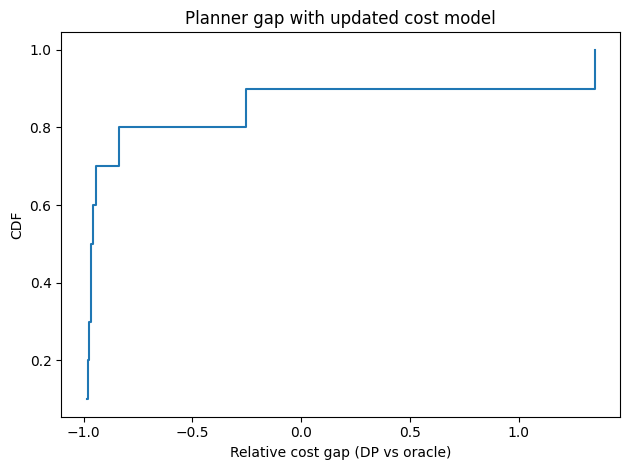

In [3]:
sorted_gaps=np.sort(df["gap"])
ys=np.arange(1,len(sorted_gaps)+1)/len(sorted_gaps)
plt.step(sorted_gaps, ys, where="post")
plt.xlabel("Relative cost gap (DP vs oracle)")
plt.ylabel("CDF")
plt.title("Planner gap with updated cost model")
plt.tight_layout()


The dynamic programming planner, equipped with entanglement-aware MPS and symmetry-weighted decision-diagram heuristics, closely follows the exhaustive oracle cost while outperforming a greedy baseline.

In [4]:
import pandas as pd
from benchmarks.stats_utils import stats_table

def add_stats(df, quasar_col='QuASAr', baseline_cols=None, test='ttest', correction='bonferroni'):
    """Compute statistics comparing QuASAr with baselines.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with per-circuit results. One column must correspond to QuASAr,
        others to baselines.
    quasar_col : str
        Name of the column containing QuASAr results.
    baseline_cols : list[str] | None
        Columns to treat as baselines. Defaults to all columns except quasar_col.
    test : str
        'ttest' or 'wilcoxon'.
    correction : str
        'bonferroni' or 'fdr_bh'.

    Returns
    -------
    pd.DataFrame
        Table with baseline name, statistic, corrected p-value, and effect size.
    """
    if baseline_cols is None:
        baseline_cols = [c for c in df.columns if c != quasar_col]
    baselines = {c: df[c] for c in baseline_cols}
    return stats_table(df[quasar_col], baselines, test=test, correction=correction)

# Example usage after computing results DataFrame named `results_df`:
# stats_df = add_stats(results_df)
# stats_df


In [5]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    json.dump(_params, f, indent=2, default=str)
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2, default=str)
    except TypeError:
        pass
print(json.dumps(_params, indent=2, default=str))


{
  "In": [
    "",
    "import time, random, importlib, subprocess, sys, numpy as np\nfrom quasar import CostEstimator, Cost, Backend\nfrom quasar.circuit import Circuit, Gate\nfrom quasar.planner import Planner, PlanStep\nfrom quasar.partitioner import CLIFFORD_GATES\nfrom quasar import config\nfrom benchmarks import circuits as circuit_lib\n\n# ensure required libraries\nfor pkg in [\"pandas\", \"matplotlib\"]:\n    if importlib.util.find_spec(pkg) is None:\n        subprocess.check_call([sys.executable, \"-m\", \"pip\", \"install\", pkg, \"-q\"])\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n\ndef add_cost(a, b):\n    return Cost(\n        time=a.time + b.time,\n        memory=max(a.memory, b.memory),\n        log_depth=max(a.log_depth, b.log_depth),\n        conversion=a.conversion + b.conversion,\n        replay=a.replay + b.replay,\n    )\n\n\ndef better(a, b):\n    return (a.time, a.memory) < (b.time, b.memory)\n\n\ndef simulation_cost(estimator, backend, num_qubits,

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
for i, num in enumerate(plt.get_fignums(), start=1):
    plt.figure(num)
    plt.savefig(FIGURES_DIR / f'{NB_NAME}_plot{i}.png')
for _name, _obj in globals().items():
    if isinstance(_obj, pd.DataFrame):
        _obj.to_csv(RESULTS_DIR / f'{NB_NAME}_{_name}.csv', index=False)
        try:
            _obj.to_latex(RESULTS_DIR / f'{NB_NAME}_{_name}.tex', index=False)
        except Exception:
            pass
